<a href="https://colab.research.google.com/github/koci1005/c-programming/blob/main/Keratoconus%20Disease%20Detection%20Using%20Custom%20CNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U image-classifiers
!pip install -U efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Augmentation of Raw Images

In [ ]:
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import os

In [ ]:

# Paths
BASE_DIR = '/content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17class'
RAW_DATA_DIR = os.path.join(BASE_DIR, 'raw')
AUG_DIR = os.path.join(BASE_DIR, 'Augmented_Images')

# Create augmentation folder
os.makedirs(AUG_DIR, exist_ok=True)

# Augmentation pipeline
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.GaussianBlur(p=0.3),
    A.GaussNoise(p=0.3)
])

In [ ]:
# Classes to process (folder names inside 'raw')
classes = ['Keratoconus', 'Normal', 'Suspect']

for cls in classes:
    input_path = os.path.join(RAW_DATA_DIR, cls)
    output_path = os.path.join(AUG_DIR, cls)
    os.makedirs(output_path, exist_ok=True)

    print(f"\n📂 Processing class: {cls}")

    # Loop through each image
    for img_path in tqdm(glob(os.path.join(input_path, '*.jpg'))):
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable images

        # Resize image
        img = cv2.resize(img, (224, 224))
        filename = os.path.basename(img_path)
        base_name, ext = os.path.splitext(filename)

        # Save the original resized image (optional)
        cv2.imwrite(os.path.join(output_path, f'org_{filename}'), img)

        # Save 2 augmented versions
        for i in range(2):
            aug_img = augmentations(image=img)['image']
            aug_name = f'aug_{i}_{base_name}{ext}'
            cv2.imwrite(os.path.join(output_path, aug_name), aug_img)

print("\n✅ All images augmented and saved in:", AUG_DIR)


📂 Processing class: Keratoconus


100%|██████████| 70/70 [00:34<00:00,  2.00it/s]



📂 Processing class: Normal


100%|██████████| 70/70 [00:29<00:00,  2.41it/s]



📂 Processing class: Suspect


100%|██████████| 70/70 [00:25<00:00,  2.72it/s]


✅ All images augmented and saved in: /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17class/Augmented_Images


#### Counting image

In [ ]:
def count_images_in_directory(directory):
    print(f"\n📁 Counting images in: {directory}")
    total = 0
    for cls in os.listdir(directory):
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            count = len(glob(os.path.join(class_path, '*.jpg')))
            print(f" - {cls}: {count} images")
            total += count    # total = total + count
    print(f"✅ Total images in {os.path.basename(directory)}: {total}")


In [ ]:
# Count images in raw and augmented directories
count_images_in_directory(RAW_DATA_DIR)
count_images_in_directory(AUG_DIR)


📁 Counting images in: /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17class/raw
 - Keratoconus: 70 images
 - Normal: 70 images
 - Suspect: 70 images
✅ Total images in raw: 210

📁 Counting images in: /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17class/Augmented_Images
 - Keratoconus: 210 images
 - Normal: 210 images
 - Suspect: 189 images
✅ Total images in Augmented_Images: 609


#### Train test and split

In [ ]:
import random
import shutil

In [ ]:
SPLIT_DIR = os.path.join(BASE_DIR, 'Split_Data')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
# Ensure output folders exist
splits = ['train', 'val', 'test']
classes = os.listdir(AUG_DIR)
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(SPLIT_DIR, split, cls), exist_ok=True)

In [ ]:
# Split the data
for cls in classes:
    cls_path = os.path.join(AUG_DIR, cls)
    images = glob(os.path.join(cls_path, '*.jpg'))  # You can add other extensions if needed
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    split_files = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    print(f"\n🔹 Splitting class '{cls}': {total} images")
    for split in splits:
        for img_path in split_files[split]:
            filename = os.path.basename(img_path)
            dst_path = os.path.join(SPLIT_DIR, split, cls, filename)
            shutil.copy(img_path, dst_path)

        print(f" - {split}: {len(split_files[split])} images")

print("\n✅ Dataset successfully split and saved in:", SPLIT_DIR)



🔹 Splitting class 'Keratoconus': 210 images
 - train: 147 images
 - val: 31 images
 - test: 32 images

🔹 Splitting class 'Normal': 210 images
 - train: 147 images
 - val: 31 images
 - test: 32 images

🔹 Splitting class 'Suspect': 189 images
 - train: 132 images
 - val: 28 images
 - test: 29 images

✅ Dataset successfully split and saved in: /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17class/Split_Data


#### image visualization

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.1 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import random
import pydicom as dicom

In [ ]:

def show_images_from_folder(base_path, num_images=16, imtype='JPEG'):
    """
    Show sample images (original or augmented) from a given folder.

    Parameters:
        base_path (str): Path to the folder containing class subfolders with images.
        num_images (int): Number of images to display (default is 16).
        imtype (str): Image type: 'TIFF', 'DICOM', 'JPEG' (default), 'PNG', etc.
    """
    # Collect all image paths from subfolders
    all_image_paths = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.tif', '.tiff', '.dcm', '.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(root, file))

    # Randomly select N images
    selected_paths = random.sample(all_image_paths, min(num_images, len(all_image_paths)))

    # Plotting
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()

    for i, img_path in enumerate(selected_paths):
        if imtype.upper() == 'DICOM':
            image = dicom.dcmread(img_path).pixel_array
            axes[i].imshow(image, cmap='bone')
        else:  # TIFF, JPEG, PNG
            image = imread(img_path)
            axes[i].imshow(image)

        axes[i].set_title(os.path.basename(os.path.dirname(img_path)))  # Show class name
        axes[i].axis('on')

    plt.tight_layout()
    plt.show()


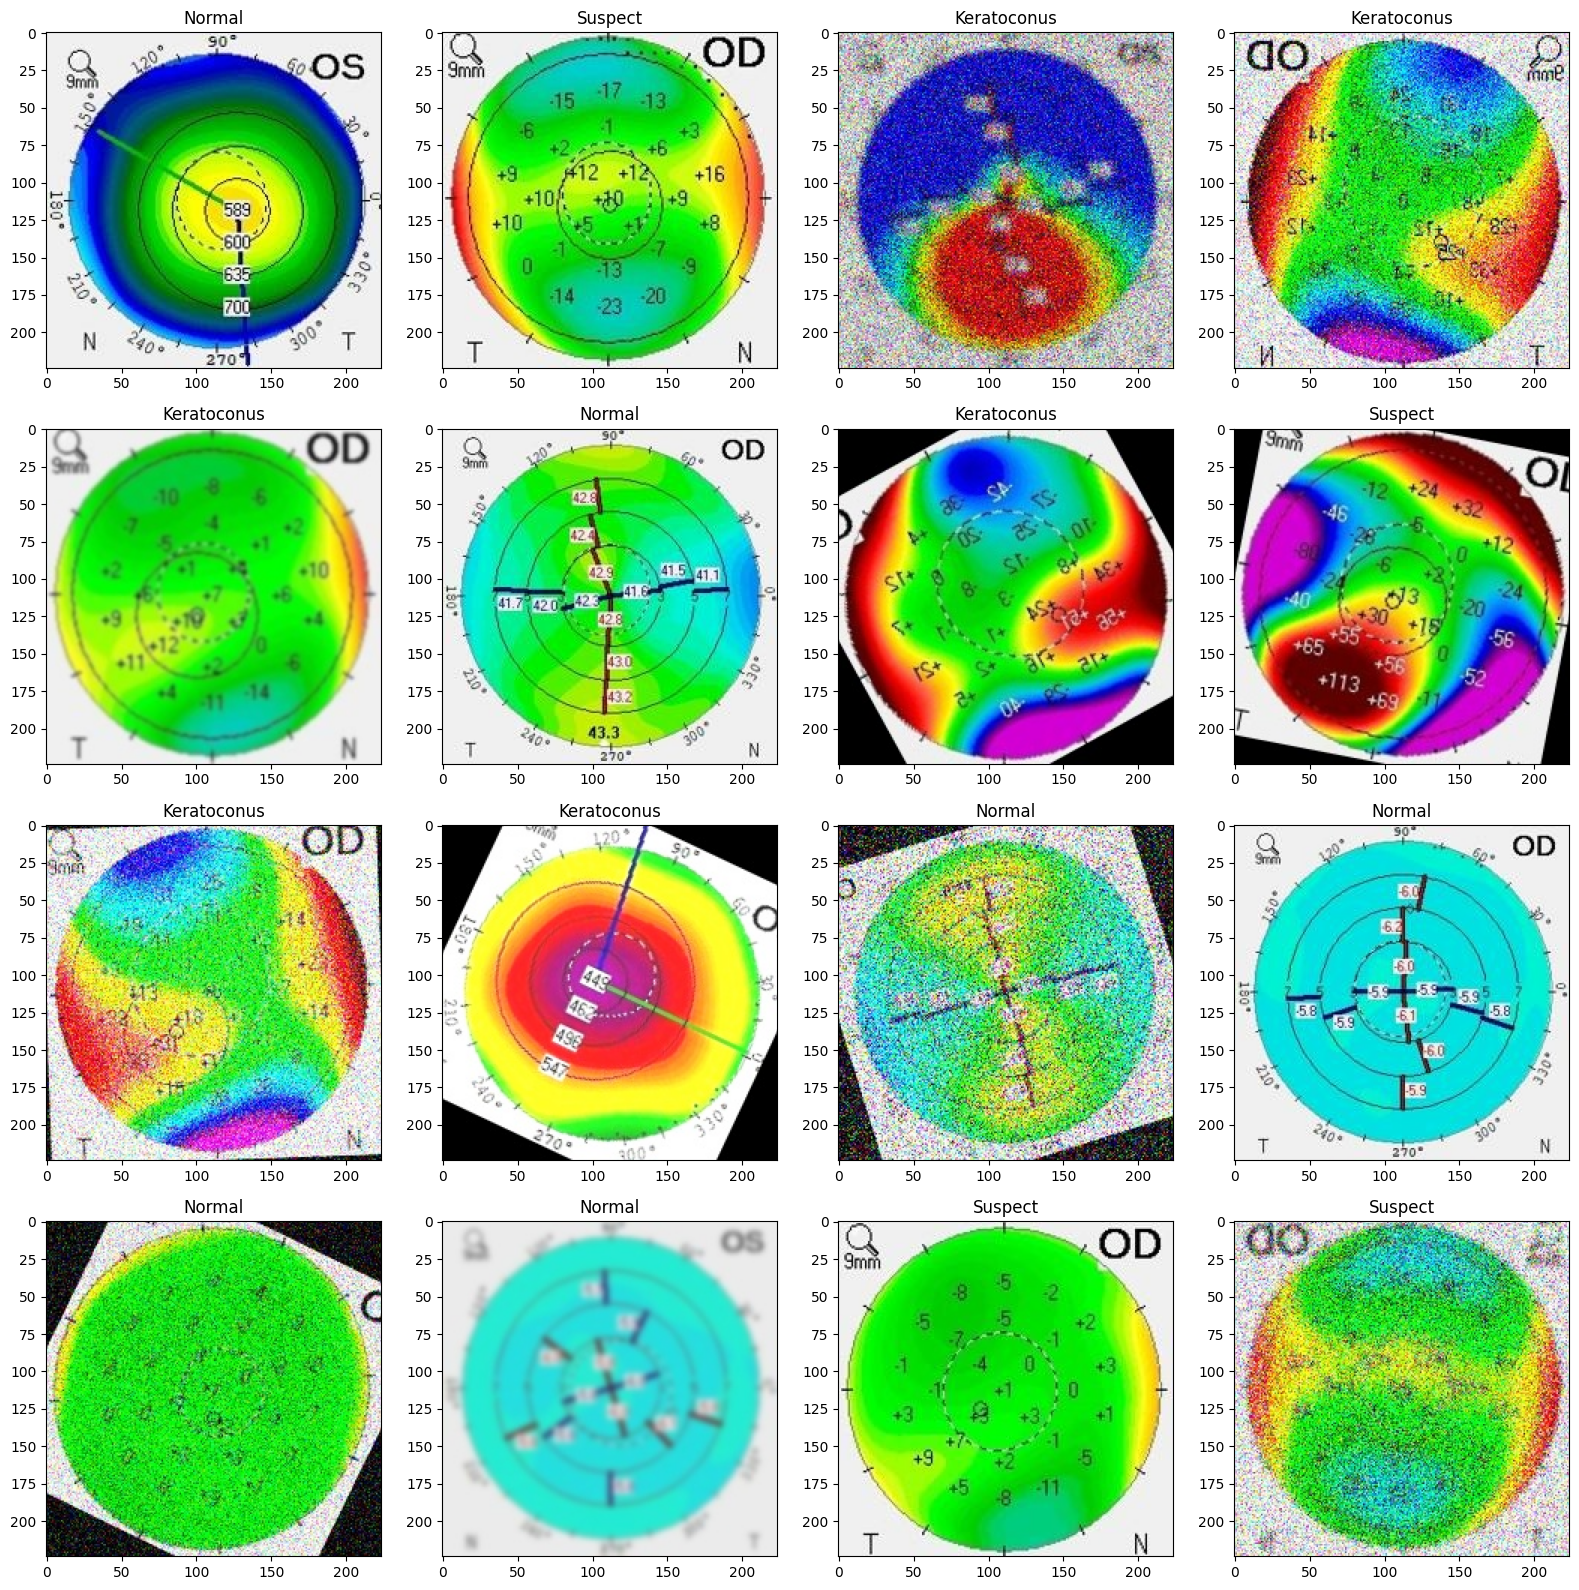

In [ ]:
aug_path = '/content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/Augmented_Images'
show_images_from_folder(aug_path, num_images=16, imtype='jpg')

#### Model Build

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, InceptionV3, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from datetime import datetime

# Google Drive model path
MODEL_NAME = "inceptionv3"  # @param ["vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]

In [ ]:
# Swish activation function
def swish(x):
    return tf.nn.swish(x)


In [ ]:

# Training parameters
EPOCHS = 250
BUFFER_SIZE = 2048

# Define Google Drive model save directory
BASE_MODEL_DIR = '/content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class'
MODEL_DIR = os.path.join(BASE_MODEL_DIR, MODEL_NAME)
os.makedirs(MODEL_DIR, exist_ok=True)

# Load the pre-trained InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze for transfer learning phase

# Custom classification head for KeraNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = Activation(swish)(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Assuming 3 classes

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile with Adam optimizer and categorical crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("✅ KeraNet Model Summary (InceptionV3-based):")
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ KeraNet Model Summary (InceptionV3-based):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,336,291 (85.21 MB)

 Trainable params: 529,411 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

#### Data directory

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/Split_Data'
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

In [ ]:
# ==== Image Parameters ====
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_dataset = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

Found 1126 images belonging to 3 classes.
Found 349 images belonging to 3 classes.
Found 340 images belonging to 3 classes.


In [ ]:
# Weight and log file paths
WEIGHT_PATH = os.path.join(MODEL_DIR, f"{MODEL_NAME}_best_weights.h5")
LOG_PATH = os.path.join(MODEL_DIR, f"{MODEL_NAME}_training_log.csv")
os.makedirs(MODEL_DIR, exist_ok=True)

#### Callback

In [ ]:
# ==== Callbacks ====
callbacks = [
    ModelCheckpoint(WEIGHT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    CSVLogger(LOG_PATH),
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-6)
]

#### Model fit

In [ ]:
# ==== Train Model ====
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=250,
    callbacks=callbacks
)

print(f"✅ Training complete. Weights saved to:\n{WEIGHT_PATH}")
print(f"📝 Training log saved to:\n{LOG_PATH}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4255 - loss: 2.0666 
Epoch 1: val_accuracy improved from -inf to 0.61032, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 595s 16s/step - accuracy: 0.4268 - loss: 2.0643 - val_accuracy: 0.6103 - val_loss: 0.9942 - learning_rate: 0.0010
Epoch 2/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5844 - loss: 1.5940
Epoch 2: val_accuracy did not improve from 0.61032
36/36 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.5847 - loss: 1.5919 - val_accuracy: 0.5903 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 3/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6451 - loss: 1.1952
Epoch 3: val_accuracy improved from 0.61032 to 0.62464, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.6453 - loss: 1.1947 - val_accuracy: 0.6246 - val_loss: 0.8729 - learning_rate: 0.0010
Epoch 4/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7080 - loss: 0.8953
Epoch 4: val_accuracy improved from 0.62464 to 0.66189, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.7075 - loss: 0.8987 - val_accuracy: 0.6619 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 5/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6884 - loss: 0.8901
Epoch 5: val_accuracy did not improve from 0.66189
36/36 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.6881 - loss: 0.8915 - val_accuracy: 0.6619 - val_loss: 0.7958 - learning_rate: 0.0010
Epoch 6/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7212 - loss: 0.7771
Epoch 6: val_accuracy did not improve from 0.66189
36/36 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.7212 - loss: 0.7771 - val_accuracy: 0.6562 - val_loss: 0.8443 - learning_rate: 0.0010
Epoch 7/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7446 - loss: 0.7905
Epoch 7: val_accuracy improved from 0.66189 to 0.72206, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 171s 5s/step - accuracy: 0.7447 - loss: 0.7899 - val_accuracy: 0.7221 - val_loss: 0.7624 - learning_rate: 0.0010
Epoch 8/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7593 - loss: 0.7076
Epoch 8: val_accuracy did not improve from 0.72206
36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7588 - loss: 0.7079 - val_accuracy: 0.7020 - val_loss: 0.7738 - learning_rate: 0.0010
Epoch 9/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7589 - loss: 0.6437
Epoch 9: val_accuracy did not improve from 0.72206
36/36 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.7583 - loss: 0.6452 - val_accuracy: 0.6848 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 10/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7560 - loss: 0.6647
Epoch 10: val_accuracy did not improve from 0.72206
36/36 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.7563 - loss: 0.6633 - val_accuracy: 0.7106 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 11/250
36/36 ━━━━━━━━━━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.8336 - loss: 0.4260 - val_accuracy: 0.7364 - val_loss: 0.6934 - learning_rate: 3.0000e-04
Epoch 17/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8486 - loss: 0.3975
Epoch 17: val_accuracy improved from 0.73639 to 0.74212, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.8482 - loss: 0.3979 - val_accuracy: 0.7421 - val_loss: 0.6786 - learning_rate: 3.0000e-04
Epoch 18/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8306 - loss: 0.4192
Epoch 18: val_accuracy improved from 0.74212 to 0.74499, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.8309 - loss: 0.4182 - val_accuracy: 0.7450 - val_loss: 0.6679 - learning_rate: 3.0000e-04
Epoch 19/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8035 - loss: 0.4247
Epoch 19: val_accuracy did not improve from 0.74499
36/36 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.8042 - loss: 0.4238 - val_accuracy: 0.7335 - val_loss: 0.6713 - learning_rate: 3.0000e-04
Epoch 20/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8695 - loss: 0.3309
Epoch 20: val_accuracy improved from 0.74499 to 0.74785, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.8692 - loss: 0.3319 - val_accuracy: 0.7479 - val_loss: 0.6501 - learning_rate: 3.0000e-04
Epoch 21/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8713 - loss: 0.3397
Epoch 21: val_accuracy improved from 0.74785 to 0.75645, saving model to /content/drive/MyDrive/Spring_2025_Course_Deep_Learning/17th_class/inceptionv3/inceptionv3_best_weights.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.8712 - loss: 0.3401 - val_accuracy: 0.7564 - val_loss: 0.6765 - learning_rate: 3.0000e-04
Epoch 22/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8412 - loss: 0.3431
Epoch 22: val_accuracy did not improve from 0.75645
36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.8415 - loss: 0.3428 - val_accuracy: 0.7364 - val_loss: 0.6985 - learning_rate: 3.0000e-04
Epoch 23/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8263 - loss: 0.3907
Epoch 23: val_accuracy did not improve from 0.75645
36/36 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.8267 - loss: 0.3898 - val_accuracy: 0.7507 - val_loss: 0.6876 - learning_rate: 3.0000e-04
Epoch 24/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8708 - loss: 0.3144
Epoch 24: val_accuracy did not improve from 0.75645
36/36 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8705 - loss: 0.3153 - val_accuracy: 0.7450 - val_loss: 0.6839 - learning_rate: 3.0000e-04
Epoch 25/250
